In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm


In [2]:
# Generate synthetic AR(p) series
np.random.seed(123)
ar_params = np.array([1, -0.5])
ma_params = np.array([1])
ar_process = ArmaProcess(ar_params, ma_params)
synthetic_ar_data = ar_process.generate_sample(nsample=100)
synthetic_ar_series = pd.Series(synthetic_ar_data)
synthetic_ar_series = synthetic_ar_series + 10

# Create y, y_plus_1, and y_minus_1
y = synthetic_ar_series
y_plus_1 = y.shift(-1)
y_minus_1 = y.shift(1)


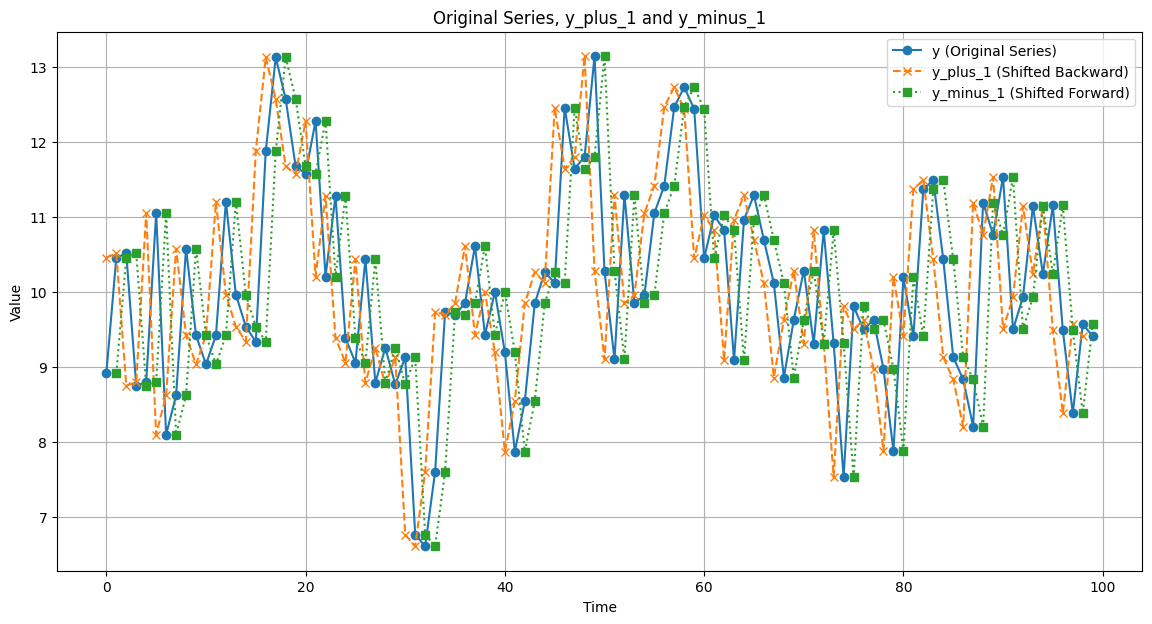

In [3]:
# Plot the series
plt.figure(figsize=(14, 7))

plt.plot(y, label='y (Original Series)', marker='o')
plt.plot(y_plus_1, label='y_plus_1 (Shifted Backward)', linestyle='--', marker='x')
plt.plot(y_minus_1, label='y_minus_1 (Shifted Forward)', linestyle=':', marker='s')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Series, y_plus_1 and y_minus_1')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# Prepare data for linear regression (drop NaN values due to shifting)
df = pd.DataFrame({'y_plus_1': y_plus_1,
                   'y': y,
                   'y_minus_1': y_minus_1
                   }).dropna()


In [5]:
# Estimation: BTF

X = df[['y_minus_1', 'y_plus_1']]
X = sm.add_constant(X)
model = sm.OLS(df['y'], X)
results = model.fit()

phi_0 = results.params['const']
phi_1 = results.params['y_minus_1']
alfa_1 = results.params['y_plus_1']

print(f'phi_0: {phi_0:.6}')
print(f'phi_1: {phi_1:.6}')
print(f'alfa_1: {alfa_1:.6}')

phi_0: 1.93006
phi_1: 0.400001
alfa_1: 0.409197


In [6]:
# Estimation: AR(1)

X_2 = df[['y_minus_1']]
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(df['y'], X_2)
results_2 = model_2.fit()

theta_0 = results_2.params['const']
theta_1 = results_2.params['y_minus_1']

print(f'theta_0: {theta_0:.6}')
print(f'theta_1: {theta_1:.6}')


theta_0: 4.73029
theta_1: 0.531009


In [7]:
t_1 = phi_0 / (1 - (2*alfa_1))
t_2 = (phi_1 - alfa_1) / (1 - (2*alfa_1))
t_3 = 1 - (2*alfa_1)

# - - - - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - #

# All models (NO resid)
y_btf = results.predict(X)
y_ar_1 = results_2.predict(X_2)
y_btf_reb = t_1 + (t_2 * y_minus_1)

# - - - - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - #

# # All models (WITH resid)
# y_btf = results.predict(X) + results.resid
# y_ar_1 = results_2.predict(X_2) + results_2.resid
# y_btf_reb = t_1 + (t_2 * y_minus_1) + (results.resid / t_3)

# - - - - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - - - - - - - - - - - #

all_models = pd.DataFrame({
                      'y': y,
                      'y_btf': y_btf,
                      'y_ar_1': y_ar_1,
                      'y_btf_reb': y_btf_reb,
                      })


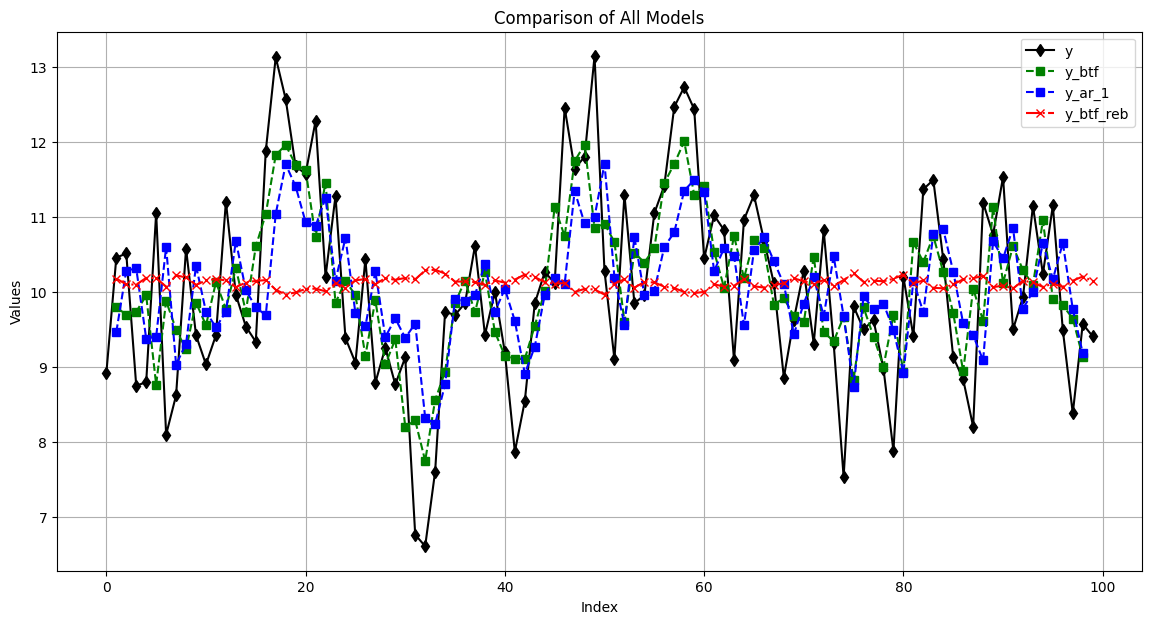

In [8]:
import matplotlib.pyplot as plt

# Define custom styles for each series
styles = {
    'y': {'linestyle': '-', 'color': 'black', 'marker': 'd'},
    'y_btf': {'linestyle': '--', 'color': 'green', 'marker': 's'},
    'y_ar_1': {'linestyle': '--', 'color': 'blue', 'marker': 's'},
    'y_btf_reb': {'linestyle': '-.', 'color': 'red', 'marker': 'x'},
}

# Plot all series in the same graph with custom styles
plt.figure(figsize=(14, 7))

for column in all_models.columns:
    plt.plot(all_models[column], 
             linestyle=styles[column]['linestyle'], 
             color=styles[column]['color'], 
             marker=styles[column]['marker'], 
             label=column)

# Add title and labels
plt.title('Comparison of All Models')
plt.xlabel('Index')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


In [9]:
print(round(results.mse_model, 4))
print(round(results_2.mse_model, 4))

38.0966
49.7899


In [10]:
for model, matrix in zip([results, results_2], [X, X_2]):

    # Make predictions
    predictions = model.predict(matrix)

    # Calculate MAPE
    actual = df['y']
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100

    print(f'MAPE: {mape:.2f}%')

MAPE: 8.62%
MAPE: 9.70%
